# Merging of the different MIMIC data sources

##### This file takes as inputs : 

-LAB_processed (from notebook LabEvents) with the pre-selected and cleaned lab measurements of the patients

-INPUTS_processed (from notebook Admissions) with the pre-selected and cleaned inputs to the patients

-Admissions_processed (from the notebook Admissions) with the death label of the patients

-Diagnoses_ICD with the ICD9 codes of each patient.

##### This notebook outputs :

-death_tags.csv. A dataframe with the patient id and the corresponding death label

-complete_tensor_csv. A dataframe containing all the measurments in tensor version.

-complete_tensor_train.csv. A dataframe containing all the training measurments in tensor version.

-complete_tensor_val.csv. A dataframe containing all the validation measurments in tensor version.

-complete_covariates.csv. A dataframe with the ICD9 covariates codes (binary) of each patient index.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
from datetime import timedelta
import numpy as np

file_path="D:/mimic_iii/csv/"
outfile_path="D:/mimic_iii/clean_data/"

In [6]:
lab_df=pd.read_csv(file_path+"LAB_processed.csv")[["SUBJECT_ID","HADM_ID","CHARTTIME","VALUENUM","LABEL"]]
inputs_df=pd.read_csv(file_path+"INPUTS_processed.csv")[["SUBJECT_ID","HADM_ID","CHARTTIME","AMOUNT","LABEL"]]
outputs_df=pd.read_csv(file_path+"OUTPUTS_processed.csv")[["SUBJECT_ID","HADM_ID","CHARTTIME","VALUE","LABEL"]]
presc_df=pd.read_csv(file_path+"PRESCRIPTIONS_processed.csv")[["SUBJECT_ID","HADM_ID","CHARTTIME","DOSE_VAL_RX","DRUG"]]

In [7]:
#Process names of columns to have the same everywhere.

#Change the name of amount. Valuenum for every table
inputs_df["VALUENUM"]=inputs_df["AMOUNT"]
inputs_df.head()
inputs_df=inputs_df.drop(columns=["AMOUNT"]).copy()

#Change the name of amount. Valuenum for every table
outputs_df["VALUENUM"]=outputs_df["VALUE"]
outputs_df=outputs_df.drop(columns=["VALUE"]).copy()

#Change the name of amount. Valuenum for every table
presc_df["VALUENUM"]=presc_df["DOSE_VAL_RX"]
presc_df=presc_df.drop(columns=["DOSE_VAL_RX"]).copy()
presc_df["LABEL"]=presc_df["DRUG"]
presc_df=presc_df.drop(columns=["DRUG"]).copy()


#Tag to distinguish between lab and inputs events
inputs_df["Origin"]="Inputs"
lab_df["Origin"]="Lab"
outputs_df["Origin"]="Outputs"
presc_df["Origin"]="Prescriptions"


#merge both dfs.
merged_df1=(inputs_df.append(lab_df)).reset_index()
merged_df2=(merged_df1.append(outputs_df)).reset_index()
merged_df2.drop(columns="level_0",inplace=True)
merged_df=(merged_df2.append(presc_df)).reset_index()


#Check that all labels have different names.
assert(merged_df["LABEL"].nunique()==(inputs_df["LABEL"].nunique()+lab_df["LABEL"].nunique()+outputs_df["LABEL"].nunique()+presc_df["LABEL"].nunique()))


In [8]:
merged_df.head()

,level_0,index,SUBJECT_ID,HADM_ID,CHARTTIME,LABEL,VALUENUM,Origin
0,0,0.0,27063,139787.0,2133-02-05 06:29:00,Potassium Chloride,1.354906,Inputs
1,1,1.0,27063,139787.0,2133-02-05 06:59:00,Potassium Chloride,1.354906,Inputs
2,2,2.0,27063,139787.0,2133-02-05 07:29:00,Potassium Chloride,1.354906,Inputs
3,3,3.0,27063,139787.0,2133-02-05 07:59:00,Potassium Chloride,1.354906,Inputs
4,4,4.0,27063,139787.0,2133-02-05 08:29:00,Potassium Chloride,1.354906,Inputs


In [9]:
#Set the reference time as the lowest chart time for each admission.
merged_df['CHARTTIME']=pd.to_datetime(merged_df["CHARTTIME"], format='%Y-%m-%d %H:%M:%S')
ref_time=merged_df.groupby("HADM_ID")["CHARTTIME"].min()

merged_df_1=pd.merge(ref_time.to_frame(name="REF_TIME"),merged_df,left_index=True,right_on="HADM_ID")
merged_df_1["TIME_STAMP"]=merged_df_1["CHARTTIME"]-merged_df_1["REF_TIME"]
assert(len(merged_df_1.loc[merged_df_1["TIME_STAMP"]<timedelta(hours=0)].index)==0)

In [10]:
#Create a label code (int) for the labels.
label_dict=dict(zip(list(merged_df_1["LABEL"].unique()),range(len(list(merged_df_1["LABEL"].unique())))))
merged_df_1["LABEL_CODE"]=merged_df_1["LABEL"].map(label_dict)

merged_df_short=merged_df_1[["HADM_ID","VALUENUM","TIME_STAMP","LABEL_CODE","Origin"]]

#To do : store the label dictionnary in a csv file.

In [11]:
label_dict_df=pd.Series(merged_df_1["LABEL"].unique()).reset_index()
label_dict_df.columns=["index","LABEL"]
label_dict_df["LABEL_CODE"]=label_dict_df["LABEL"].map(label_dict)
label_dict_df.drop(columns=["index"],inplace=True)
label_dict_df.to_csv(outfile_path+"label_dict.csv")

#### Time binning of the data
First we select the data up to a certain time limit (48 hours)

In [12]:
#Now only select values within 48 hours.
merged_df_short=merged_df_short.loc[(merged_df_short["TIME_STAMP"]<timedelta(hours=48))]
print("Number of patients considered :"+str(merged_df_short["HADM_ID"].nunique()))

Number of patients considered :23457


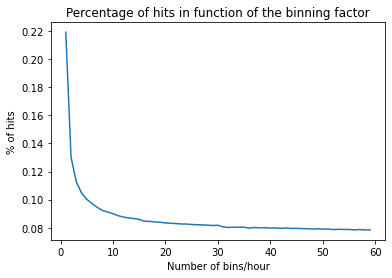

In [13]:
#Plot the number of "hits" based on the binning. That is, the number of measurements falling into the same bin in function of the number of bins
bins_num=range(1,60)
merged_df_short_binned=merged_df_short.copy()
hits_vec=[]
for bin_k in bins_num:
    time_stamp_str="TIME_STAMP_Bin_"+str(bin_k)
    merged_df_short_binned[time_stamp_str]=round(merged_df_short_binned["TIME_STAMP"].dt.total_seconds()*bin_k/(100*36)).astype(int)
    hits_prop=merged_df_short_binned.duplicated(subset=["HADM_ID","LABEL_CODE",time_stamp_str]).sum()/len(merged_df_short_binned.index)
    hits_vec+=[hits_prop]
plt.plot(bins_num,hits_vec)
plt.title("Percentage of hits in function of the binning factor")
plt.xlabel("Number of bins/hour")
plt.ylabel("% of hits")
plt.show()

In [14]:
#We choose 60 bins per hour. We now need to aggregate the data in different ways.
bin_k=60
merged_df_short["TIME"]=round(merged_df_short_binned["TIME_STAMP"].dt.total_seconds()*bin_k/(100*36)).astype(int)

#For lab, we have to average the duplicates.
lab_subset=merged_df_short.loc[merged_df_short["Origin"]=="Lab",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
lab_subset["KEY_ID"]=lab_subset["HADM_ID"].astype(str)+"/"+lab_subset["TIME"].astype(str)+"/"+lab_subset["LABEL_CODE"].astype(str)
lab_subset["VALUENUM"]=lab_subset["VALUENUM"].astype(float)

lab_subset_s=lab_subset.groupby("KEY_ID")["VALUENUM"].mean().to_frame().reset_index()

lab_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
lab_s=pd.merge(lab_subset,lab_subset_s,on="KEY_ID")
assert(not lab_s.isnull().values.any())

#For inputs, we have to sum the duplicates.
input_subset=merged_df_short.loc[merged_df_short["Origin"]=="Inputs",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
input_subset["KEY_ID"]=input_subset["HADM_ID"].astype(str)+"/"+input_subset["TIME"].astype(str)+"/"+input_subset["LABEL_CODE"].astype(str)
input_subset["VALUENUM"]=input_subset["VALUENUM"].astype(float)

input_subset_s=input_subset.groupby("KEY_ID")["VALUENUM"].sum().to_frame().reset_index()

input_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
input_s=pd.merge(input_subset,input_subset_s,on="KEY_ID")
assert(not input_s.isnull().values.any())

#For outpus, we have to sum the duplicates as well.
output_subset=merged_df_short.loc[merged_df_short["Origin"]=="Outputs",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
output_subset["KEY_ID"]=output_subset["HADM_ID"].astype(str)+"/"+output_subset["TIME"].astype(str)+"/"+output_subset["LABEL_CODE"].astype(str)
output_subset["VALUENUM"]=output_subset["VALUENUM"].astype(float)

output_subset_s=output_subset.groupby("KEY_ID")["VALUENUM"].sum().to_frame().reset_index()

output_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
output_s=pd.merge(output_subset,output_subset_s,on="KEY_ID")
assert(not output_s.isnull().values.any())

#For prescriptions, we have to sum the duplicates as well.
presc_subset=merged_df_short.loc[merged_df_short["Origin"]=="Prescriptions",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
presc_subset["KEY_ID"]=presc_subset["HADM_ID"].astype(str)+"/"+presc_subset["TIME"].astype(str)+"/"+presc_subset["LABEL_CODE"].astype(str)
presc_subset["VALUENUM"]=presc_subset["VALUENUM"].astype(float)

presc_subset_s=presc_subset.groupby("KEY_ID")["VALUENUM"].sum().to_frame().reset_index()

presc_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
presc_s=pd.merge(presc_subset,presc_subset_s,on="KEY_ID")
assert(not presc_s.isnull().values.any())

#Now remove the duplicates/
lab_s=(lab_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()
input_s=(input_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()
output_s=(output_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()
presc_s=(presc_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()

#We append both subsets together to form the complete dataframe
complete_df1=lab_s.append(input_s)
complete_df2=complete_df1.append(output_s)
complete_df=complete_df2.append(presc_s)


assert(sum(complete_df.duplicated(subset=["HADM_ID","LABEL_CODE","TIME"])==True)==0) #Check if no duplicates anymore.

# We remove patients with less than 50 observations.
id_counts=complete_df.groupby("HADM_ID").count()
id_list=list(id_counts.loc[id_counts["TIME"]<50].index)
complete_df=complete_df.drop(complete_df.loc[complete_df["HADM_ID"].isin(id_list)].index).copy()

In [15]:
#We also choose 10 bins per hour. We now need to aggregate the data in different ways.
bin_k=10
merged_df_short["TIME"]=round(merged_df_short_binned["TIME_STAMP"].dt.total_seconds()*bin_k/(100*36))

#For lab, we have to average the duplicates.
lab_subset=merged_df_short.loc[merged_df_short["Origin"]=="Lab",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
lab_subset["KEY_ID"]=lab_subset["HADM_ID"].astype(str)+"/"+lab_subset["TIME"].astype(str)+"/"+lab_subset["LABEL_CODE"].astype(str)
lab_subset["VALUENUM"]=lab_subset["VALUENUM"].astype(float)

lab_subset_s=lab_subset.groupby("KEY_ID")["VALUENUM"].mean().to_frame().reset_index()

lab_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
lab_s=pd.merge(lab_subset,lab_subset_s,on="KEY_ID")
assert(not lab_s.isnull().values.any())

#For inputs, we have to sum the duplicates.
input_subset=merged_df_short.loc[merged_df_short["Origin"]=="Inputs",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
input_subset["KEY_ID"]=input_subset["HADM_ID"].astype(str)+"/"+input_subset["TIME"].astype(str)+"/"+input_subset["LABEL_CODE"].astype(str)
input_subset["VALUENUM"]=input_subset["VALUENUM"].astype(float)

input_subset_s=input_subset.groupby("KEY_ID")["VALUENUM"].sum().to_frame().reset_index()

input_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
input_s=pd.merge(input_subset,input_subset_s,on="KEY_ID")
assert(not input_s.isnull().values.any())

#For outpus, we have to sum the duplicates as well.
output_subset=merged_df_short.loc[merged_df_short["Origin"]=="Outputs",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
output_subset["KEY_ID"]=output_subset["HADM_ID"].astype(str)+"/"+output_subset["TIME"].astype(str)+"/"+output_subset["LABEL_CODE"].astype(str)
output_subset["VALUENUM"]=output_subset["VALUENUM"].astype(float)

output_subset_s=output_subset.groupby("KEY_ID")["VALUENUM"].sum().to_frame().reset_index()

output_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
output_s=pd.merge(output_subset,output_subset_s,on="KEY_ID")
assert(not output_s.isnull().values.any())

#For prescriptions, we have to sum the duplicates as well.
presc_subset=merged_df_short.loc[merged_df_short["Origin"]=="Prescriptions",["HADM_ID","TIME","LABEL_CODE","VALUENUM"]]
presc_subset["KEY_ID"]=presc_subset["HADM_ID"].astype(str)+"/"+presc_subset["TIME"].astype(str)+"/"+presc_subset["LABEL_CODE"].astype(str)
presc_subset["VALUENUM"]=presc_subset["VALUENUM"].astype(float)

presc_subset_s=presc_subset.groupby("KEY_ID")["VALUENUM"].sum().to_frame().reset_index()

presc_subset.rename(inplace=True,columns={"VALUENUM":"ExVALUENUM"})
presc_s=pd.merge(presc_subset,presc_subset_s,on="KEY_ID")
assert(not presc_s.isnull().values.any())

#Now remove the duplicates/
lab_s=(lab_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()
input_s=(input_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()
output_s=(output_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()
presc_s=(presc_s.drop_duplicates(subset=["HADM_ID","LABEL_CODE","TIME"]))[["HADM_ID","TIME","LABEL_CODE","VALUENUM"]].copy()

#We append both subsets together to form the complete dataframe
complete_df1=lab_s.append(input_s)
complete_df2=complete_df1.append(output_s)
complete_df10=complete_df2.append(presc_s)


assert(sum(complete_df10.duplicated(subset=["HADM_ID","LABEL_CODE","TIME"])==True)==0) #Check if no duplicates anymore.

# We remove patients with less than 50 observations.
id_counts=complete_df10.groupby("HADM_ID").count()
id_list=list(id_counts.loc[id_counts["TIME"]<50].index)
complete_df10=complete_df10.drop(complete_df10.loc[complete_df10["HADM_ID"].isin(id_list)].index).copy()

In [16]:
complete_df10["TIME"].max()

480.0

# Dataframe creation for Tensor Decomposition

Creation of a unique index for the admissions id.

In [17]:
#Creation of a unique index
unique_ids=np.arange(complete_df["HADM_ID"].nunique())
np.random.shuffle(unique_ids)
d=dict(zip(complete_df["HADM_ID"].unique(),unique_ids))


In [18]:
Unique_id_dict=pd.Series(complete_df["HADM_ID"].unique()).reset_index().copy()
Unique_id_dict.columns=["index","HADM_ID"]
Unique_id_dict["UNIQUE_ID"]=Unique_id_dict["HADM_ID"].map(d)
Unique_id_dict.to_csv(outfile_path+"UNIQUE_ID_dict.csv")

In [19]:
unique_id_df   = pd.read_csv(outfile_path+"UNIQUE_ID_dict.csv")
d = dict(zip(unique_id_df["HADM_ID"].values,unique_id_df["UNIQUE_ID"].values))


### Death tags data set

In [20]:
admissions=pd.read_csv(file_path+"Admissions_processed.csv")
death_tags_s=admissions.groupby("HADM_ID")["DEATHTAG"].unique().astype(int).to_frame().reset_index()
death_tags_df=death_tags_s.loc[death_tags_s["HADM_ID"].isin(complete_df["HADM_ID"])].copy()
death_tags_df["UNIQUE_ID"]=death_tags_df["HADM_ID"].map(d)
death_tags_df.sort_values(by="UNIQUE_ID",inplace=True)
death_tags_df.rename(columns={"DEATHTAG":"Value"},inplace=True)
death_tags_df.to_csv(outfile_path+"complete_death_tags.csv")

### comparison with sapsii

In [21]:
#SAPSII data
saps=pd.read_csv(file_path+'sapsii.csv')
valid_hadm_id=complete_df["HADM_ID"].unique()
saps=saps.loc[saps["hadm_id"].isin(list(valid_hadm_id))].copy()
saps["HADM_ID"]=saps["hadm_id"]
saps.head()

,subject_id,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,pao2fio2_score,...,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,HADM_ID
1,27513,163557,200003,30,0.106398,7,4.0,5.0,0.0,NaN,...,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0,8,163557
3,20707,129310,200007,18,0.029295,7,0.0,5.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,6,129310
8,9514,127229,200014,43,0.305597,18,2.0,5.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,127229
16,76603,179633,200024,52,0.507019,18,4.0,5.0,0.0,6.0,...,6.0,0.0,3.0,1.0,3.0,NaN,0.0,0,6,179633
17,19167,164161,200025,29,0.096698,7,0.0,5.0,0.0,6.0,...,0.0,0.0,3.0,0.0,0.0,NaN,0.0,0,8,164161


In [22]:
saps["SUM_score"]=saps[[ 'hr_score', 'sysbp_score', 'temp_score', 'pao2fio2_score','uo_score', 'bun_score', 'wbc_score', 'potassium_score', 'sodium_score','bicarbonate_score', 'bilirubin_score', 'gcs_score']].sum(axis=1)
saps["X"]=-7.7631 + 0.0737 * saps["SUM_score"] + 0.9971 * (np.log(saps["SUM_score"] + 1))
saps["PROB"]=1/(1+np.exp(saps["X"]))
saps.head()


,subject_id,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,pao2fio2_score,...,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,HADM_ID,SUM_score,X,PROB
1,27513,163557,200003,30,0.106398,7,4.0,5.0,0.0,NaN,...,0.0,3.0,0.0,0.0,0,8,163557,15.0,-3.893052,0.019976
3,20707,129310,200007,18,0.029295,7,0.0,5.0,0.0,NaN,...,0.0,0.0,NaN,0.0,0,6,129310,5.0,-5.608037,0.003655
8,9514,127229,200014,43,0.305597,18,2.0,5.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0,8,127229,17.0,-3.628210,0.025876
16,76603,179633,200024,52,0.507019,18,4.0,5.0,0.0,6.0,...,1.0,3.0,NaN,0.0,0,6,179633,28.0,-2.341969,0.087706
17,19167,164161,200025,29,0.096698,7,0.0,5.0,0.0,6.0,...,0.0,0.0,NaN,0.0,0,8,164161,14.0,-4.031103,0.017445


In [23]:
saps.to_csv(file_path+"sapsii_processed.csv")

In [24]:
saps_death=pd.merge(death_tags_df,saps,on="HADM_ID")
saps_death["DEATHTAG"] = saps_death["Value"]
saps_death = saps_death.drop(columns="Value").copy()
saps_death.head()

,HADM_ID,UNIQUE_ID,subject_id,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,...,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,SUM_score,X,PROB,DEATHTAG
0,147313,0,17074,147313,281800,23,0.052195,7,2.0,5.0,...,0.0,0.0,NaN,0.0,0,0,16.0,-3.758903,0.022778,0
1,128017,1,28620,128017,290888,28,0.087706,12,2.0,5.0,...,0.0,0.0,0.0,0.0,0,0,16.0,-3.758903,0.022778,0
2,157614,2,52846,157614,255243,50,0.460662,18,11.0,5.0,...,0.0,0.0,0.0,0.0,0,6,26.0,-2.560621,0.071716,0
3,128369,3,23474,128369,228884,27,0.079390,12,0.0,0.0,...,0.0,0.0,0.0,0.0,0,6,9.0,-4.803892,0.008131,0
4,128310,4,23537,128310,238311,40,0.247443,15,0.0,13.0,...,0.0,0.0,NaN,0.0,0,0,25.0,-2.671952,0.064649,0


In [25]:
y_pred=np.array(saps_death["PROB"])
y_pred_full=np.array(saps_death["sapsii_prob"])
y=np.array(saps_death["DEATHTAG"])
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y,y_pred))
print(roc_auc_score(y,y_pred_full))

0.7567831475340965
0.8017870035559423


### Tensor Dataset

In [19]:
complete_df["UNIQUE_ID"] = complete_df["HADM_ID"].map(d)

In [20]:
#ICD9 codes
ICD_diag=pd.read_csv(file_path+"DIAGNOSES_ICD.csv")

In [21]:
main_diag=ICD_diag.loc[(ICD_diag["SEQ_NUM"]==1)]
complete_tensor=pd.merge(complete_df,main_diag[["HADM_ID","ICD9_CODE"]],on="HADM_ID")

#Only select the first 3 digits of each ICD9 code.
complete_tensor["ICD9_short"]=complete_tensor["ICD9_CODE"].astype(str).str[:3]
#Check that all codes are 3 digits long.
str_len=complete_tensor["ICD9_short"].str.len()
assert(str_len.loc[str_len!=3].count()==0)

#Finer encoding (3 digits)
hot_encodings=pd.get_dummies(complete_tensor["ICD9_short"])
complete_tensor[hot_encodings.columns]=hot_encodings
complete_tensor_nocov=complete_tensor[["UNIQUE_ID","LABEL_CODE","TIME"]+["VALUENUM"]].copy()

complete_tensor_nocov.rename(columns={"TIME":"TIME_STAMP"},inplace=True)

### Normalization of the data (N(0,1))

In [22]:
#Add a column with the mean and std of each different measurement type and then normalize them.
d_mean=dict(complete_tensor_nocov.groupby("LABEL_CODE")["VALUENUM"].mean())
complete_tensor_nocov["MEAN"]=complete_tensor_nocov["LABEL_CODE"].map(d_mean)
d_std=dict(complete_tensor_nocov.groupby("LABEL_CODE")["VALUENUM"].std())
complete_tensor_nocov["STD"]=complete_tensor_nocov["LABEL_CODE"].map(d_std)
complete_tensor_nocov["VALUENORM"]=(complete_tensor_nocov["VALUENUM"]-complete_tensor_nocov["MEAN"])/complete_tensor_nocov["STD"]


### Train-Validation-Test split
Random sampling

In [23]:
#Split training_validation_test sets RANDOM DIVISION.

df_train,df_test =train_test_split(complete_tensor_nocov,test_size=0.1) 

#Make sure that patients of the test set have instances in the training set. (same with labels but this should be nearly certain)
assert(len(df_test.loc[~df_test["UNIQUE_ID"].isin(df_train["UNIQUE_ID"])].index)==0)
assert(len(df_test.loc[~df_test["LABEL_CODE"].isin(df_train["LABEL_CODE"])].index)==0)


In [24]:
#First train_val fold
df_train1,df_val1 =train_test_split(df_train,test_size=0.2) 

#Make sure that patients of the test set have instances in the training set. (same with labels but this should be nearly certain)
assert(len(df_val1.loc[~df_val1["UNIQUE_ID"].isin(df_train1["UNIQUE_ID"])].index)==0)
assert(len(df_val1.loc[~df_val1["LABEL_CODE"].isin(df_train1["LABEL_CODE"])].index)==0)

In [25]:
#Second train_val fold
df_train2,df_val2 =train_test_split(df_train,test_size=0.2) 

#Make sure that patients of the test set have instances in the training set. (same with labels but this should be nearly certain)
assert(len(df_val2.loc[~df_val2["UNIQUE_ID"].isin(df_train2["UNIQUE_ID"])].index)==0)
assert(len(df_val2.loc[~df_val2["LABEL_CODE"].isin(df_train2["LABEL_CODE"])].index)==0)

In [26]:
#Third train_val fold
df_train3,df_val3 =train_test_split(df_train,test_size=0.2) 

#Make sure that patients of the test set have instances in the training set. (same with labels but this should be nearly certain)
assert(len(df_val3.loc[~df_val3["UNIQUE_ID"].isin(df_train3["UNIQUE_ID"])].index)==0)
assert(len(df_val3.loc[~df_val3["LABEL_CODE"].isin(df_train3["LABEL_CODE"])].index)==0)

#### Venn diagram of the training sets. Visualization of the number of common samples.


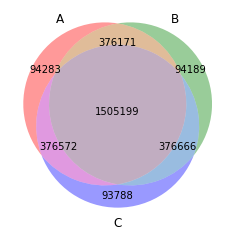

In [28]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

temp12=pd.merge(df_train1,df_train2,how="inner",on=["UNIQUE_ID","LABEL_CODE","TIME_STAMP"])
temp13=pd.merge(df_train1,df_train3,how="inner",on=["UNIQUE_ID","LABEL_CODE","TIME_STAMP"])
temp23=pd.merge(df_train2,df_train3,how="inner",on=["UNIQUE_ID","LABEL_CODE","TIME_STAMP"])
temp123=pd.merge(temp12,temp23,how="inner",on=["UNIQUE_ID","LABEL_CODE","TIME_STAMP"])

 
# Make the diagram
venn3(subsets = (len(df_train1.index)-len(temp12.index)-len(temp13.index)+len(temp123.index), len(df_train2.index)-len(temp12.index)-len(temp23.index)+len(temp123.index), len(temp12.index)-len(temp123), len(df_train3.index)-len(temp13.index)-len(temp23.index)+len(temp123.index),len(temp13.index)-len(temp123.index),len(temp23.index)-len(temp123.index),len(temp123)))
plt.show()

In [29]:
#Save locally.
complete_tensor_nocov.to_csv(outfile_path+"complete_tensor.csv") #Full data
df_train1.to_csv(outfile_path+"complete_tensor_train1.csv") #Train data
df_val1.to_csv(outfile_path+"complete_tensor_val1.csv") #Validation data
df_train2.to_csv(outfile_path+"complete_tensor_train2.csv") #Train data
df_val2.to_csv(outfile_path+"complete_tensor_val2.csv") #Validation data
df_train3.to_csv(outfile_path+"complete_tensor_train3.csv") #Train data
df_val3.to_csv(outfile_path+"complete_tensor_val3.csv") #Validation data
df_test.to_csv(outfile_path+"complete_tensor_test.csv") #Test data


#### Covariates dataset

In [30]:
#We create a data set with the covariates
covariates=complete_tensor.groupby("UNIQUE_ID").nth(0)[list(hot_encodings.columns)]
covariates.to_csv(outfile_path+"complete_covariates.csv") #save locally

## Creation of the dataset for LSTM operation

We split the data patient-wise and provide imputation methods.

In [31]:
#Unique_ids of train and test
test_prop=0.1
val_prop=0.2
sorted_unique_ids=np.sort(unique_ids)
train_unique_ids=sorted_unique_ids[:int((1-test_prop)*(1-val_prop)*len(unique_ids))]
val_unique_ids=sorted_unique_ids[int((1-test_prop)*(1-val_prop)*len(unique_ids)):int((1-test_prop)*len(unique_ids))]
test_unique_ids=sorted_unique_ids[int((1-test_prop)*len(unique_ids)):]

#### Death tags

In [32]:
death_tags_train_df=death_tags_df.loc[death_tags_df["UNIQUE_ID"].isin(list(train_unique_ids))].sort_values(by="UNIQUE_ID")
death_tags_val_df=death_tags_df.loc[death_tags_df["UNIQUE_ID"].isin(list(val_unique_ids))].sort_values(by="UNIQUE_ID")
death_tags_test_df=death_tags_df.loc[death_tags_df["UNIQUE_ID"].isin(list(test_unique_ids))].sort_values(by="UNIQUE_ID")

death_tags_train_df.to_csv(outfile_path+"LSTM_death_tags_train.csv")
death_tags_val_df.to_csv(outfile_path+"LSTM_death_tags_val.csv")
death_tags_test_df.to_csv(outfile_path+"LSTM_death_tags_test.csv")

#### Tensor split

In [33]:
#Create a segmented tensor (by patients)
complete_tensor_train=complete_tensor_nocov.loc[complete_tensor_nocov["UNIQUE_ID"].isin(list(train_unique_ids))].sort_values(by="UNIQUE_ID")
complete_tensor_val=complete_tensor_nocov.loc[complete_tensor_nocov["UNIQUE_ID"].isin(list(val_unique_ids))].sort_values(by="UNIQUE_ID")
complete_tensor_test=complete_tensor_nocov.loc[complete_tensor_nocov["UNIQUE_ID"].isin(list(test_unique_ids))].sort_values(by="UNIQUE_ID")

complete_tensor_train.to_csv(outfile_path+"LSTM_tensor_train.csv") 
complete_tensor_val.to_csv(outfile_path+"LSTM_tensor_val.csv") 
complete_tensor_test.to_csv(outfile_path+"LSTM_tensor_test.csv") 

#### Covariates split

In [34]:
covariates_train=covariates.loc[covariates.index.isin(train_unique_ids)].sort_index()
covariates_val=covariates.loc[covariates.index.isin(val_unique_ids)].sort_index()
covariates_test=covariates.loc[covariates.index.isin(test_unique_ids)].sort_index()

covariates_train.to_csv(outfile_path+"LSTM_covariates_train.csv") #save locally
covariates_val.to_csv(outfile_path+"LSTM_covariates_val.csv") #save locally
covariates_test.to_csv(outfile_path+"LSTM_covariates_test.csv") #save locally

#### Mean Imputation

In [35]:
#Vector containing the mean_values of each dimension.
mean_dims=complete_tensor_train.groupby("LABEL_CODE")["MEAN"].mean()
mean_dims.to_csv(outfile_path+"mean_features.csv")

## Dataset for GRU_D (continuous time operation)

In [36]:
#map the admission id to the unique id
complete_df10["UNIQUE_ID"]=complete_df10["HADM_ID"].map(d)
complete_df10["TIME_CONTINUOUS"]=complete_df10["TIME"]/10

In [37]:
#Add a column with the mean and std of each different measurement type and then normalize them.
d_mean=dict(complete_df10.groupby("LABEL_CODE")["VALUENUM"].mean())
complete_df10["MEAN"]=complete_df10["LABEL_CODE"].map(d_mean)
d_std=dict(complete_df10.groupby("LABEL_CODE")["VALUENUM"].std())
complete_df10["STD"]=complete_df10["LABEL_CODE"].map(d_std)
complete_df10["VALUENORM"]=(complete_df10["VALUENUM"]-complete_df10["MEAN"])/complete_df10["STD"]

assert(len(complete_df10.loc[complete_df10["VALUENORM"]==0].index)==0) #Make sure that there are no zeros. (Zeros can be used to represent missing values then)

In [38]:
max_time_bins=complete_df10.groupby("UNIQUE_ID")["TIME"].nunique().max() #This is the maximal number of different time steps in a patient time series.

In [39]:
a=complete_df10.sort_values(by=["UNIQUE_ID","TIME_CONTINUOUS"]).copy()
a.reset_index(inplace=True)

In [40]:
b=a.assign(Time_order=a.groupby('UNIQUE_ID').TIME.rank(method='dense') - 1)


In [41]:
b

,index,HADM_ID,TIME,LABEL_CODE,VALUENUM,UNIQUE_ID,TIME_CONTINUOUS,MEAN,STD,VALUENORM,Time_order
0,35242,124428.0,0.0,66,200.000000,0,0.0,108.223466,30.297684,3.029160,0.0
1,35244,124428.0,0.0,41,40.000000,0,0.0,73.054801,76.311032,-0.433159,0.0
2,35245,124428.0,0.0,38,3.000000,0,0.0,4.666986,3.343690,-0.498547,0.0
3,543919,124428.0,2.0,0,16.000000,0,0.2,14.333616,3.958092,0.421007,1.0
4,543922,124428.0,2.0,1,25.000000,0,0.2,23.683217,4.552615,0.289237,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3225035,883844,179240.0,474.0,54,1.935441,21260,47.4,13.491264,20.284640,-0.569683,142.0
3225036,883864,179240.0,475.0,55,9.969697,21260,47.5,108.984409,124.673087,-0.794195,143.0
3225037,884012,179240.0,476.0,69,1.211853,21260,47.6,2.593535,3.662185,-0.377283,144.0
3225038,883912,179240.0,477.0,73,0.496430,21260,47.7,2.350652,2.846128,-0.651489,145.0


In [ ]:
#### END OF FILE ####### (below is testing stuff.)

In [12]:
tags=pd.read_csv(outfile_path+"LSTM_death_tags_train.csv")
tags["UNIQUE_ID"].unique()

array([    0,     1,     2, ..., 15297, 15298, 15299])

In [13]:
tags=pd.read_csv(outfile_path+"LSTM_death_tags_val.csv")
tags["UNIQUE_ID"].unique()

array([15300, 15301, 15302, ..., 19122, 19123, 19124])

In [2]:
df=pd.read_csv(outfile_path+"LSTM_tensor_train.csv")

In [3]:
df["UNIQUE_ID"].unique()

array([    0,     1,     2, ..., 15297, 15298, 15299])

In [10]:
df["UNIQUE_ID"].nunique()

15300

In [4]:
df2=pd.read_csv(outfile_path+"LSTM_tensor_val.csv")

In [5]:
df2["UNIQUE_ID"].unique()

array([15300, 15301, 15302, ..., 19122, 19123, 19124])

In [8]:
df3=pd.concat([df,df2])

In [9]:
df3["UNIQUE_ID"].unique()

array([    0,     1,     2, ..., 19122, 19123, 19124])

In [151]:
means_df=pd.Series.from_csv("~/Documents/Data/Full_MIMIC/Clean_data/mean_features.csv")
means_vec=torch.tensor(means_df.as_matrix())

/Users/XXXX/miniconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [153]:
means_vec.size()

torch.Size([96])

In [144]:
mean_dims

LABEL_CODE
0      14.332368
1      23.683532
2       8.319696
3     105.072921
4       1.349956
5     135.362454
6       2.001855
7       3.504950
8       4.151537
9     138.632943
10    119.696930
11    317.702850
12      2.099668
13     24.828327
14      0.305753
15      1.108482
16     32.246985
17     11.025442
18     14.218029
19     30.393274
20     34.072047
21     89.270204
22      5.021936
23     77.249455
24    212.120463
25     14.662603
26      3.706547
27     11.987865
28     39.857678
29     -1.064501
         ...    
66    108.225806
67    211.900036
68    135.809443
69      3.275288
70     70.765905
71     40.142469
72     11.517381
73      2.691385
74      5.582121
75     73.378317
76    315.733581
77     20.315678
78    605.229537
79    235.878698
80      1.307061
81     59.813022
82    574.522817
83     42.854298
84    108.222934
85    196.146218
86    174.020606
87     30.696462
88    819.275713
89      1.757776
90      0.491271
91     92.211538
92    187.327189
93 

In [4]:
cov=pd.read_csv(file_path+"complete_covariates.csv")
df_train=pd.read_csv(file_path+"complete_tensor_train1.csv")
df_val=pd.read_csv(file_path+"complete_tensor_val1.csv")
deaths=pd.read_csv(file_path+"complete_death_tags.csv")
df=pd.read_csv(file_path+"complete_tensor.csv")

## Create a segmented dataset by patients for actual testing.

In [15]:
unique_ids=cov["UNIQUE_ID"]
train_unique_ids,test_unique_ids=train_test_split(unique_ids,test_size=0.1)

In [20]:
df_segment_train=df.loc[df["UNIQUE_ID"].isin(list(train_unique_ids))]
df_segment_test=df.loc[df["UNIQUE_ID"].isin(list(test_unique_ids))]
cov_segment_train=cov.loc[cov["UNIQUE_ID"].isin(list(train_unique_ids))]
cov_segment_test=cov.loc[cov["UNIQUE_ID"].isin(list(test_unique_ids))]

In [21]:
df_segment_train.to_csv(file_path+"segmented_tensor_train.csv")
df_segment_test.to_csv(file_path+"segmented_tensor_test.csv")
cov_segment_train.to_csv(file_path+"segmented_covariates_train.csv")
cov_segment_test.to_csv(file_path+"segmented_covariates_test.csv")

In [1]:
#list(df["UNIQUE_ID"].unique())

In [6]:
df_train['UNIQUE_ID'].nunique()

23341

In [7]:
df_val['UNIQUE_ID'].nunique()

23336

In [10]:
deaths["UNIQUE_ID"].nunique()

23341

In [11]:
df["UNIQUE_ID"].nunique()

23341

In [87]:
import torch

In [89]:
a=torch.tensor([3,2,1])

In [96]:
b=a.repeat(10,5,1)

In [97]:
b.shape

torch.Size([10, 5, 3])

In [ ]:
torch.cumsum(b)

In [2]:
import torch
import numpy as np

In [15]:
a=torch.tensor([np.nan, 3, 4, np.nan])

In [16]:
observed_mask=a==a

In [19]:
observed_mask

tensor([ 0,  1,  1,  0], dtype=torch.uint8)

In [9]:
a=torch.randn((3,4,5))
b=torch.randn((3,4,5))
c=torch.randn((3,4,5))

In [11]:
d=torch.cat((a,b,c))
d.size()

torch.Size([9, 4, 5])

In [12]:
print(d.dtype)

torch.float32


In [13]:
z=torch.zeros((4))

In [17]:
torch.zeros((4)).masked_scatter_(1-observed_mask,a)

tensor([nan.,   0.,   0.,   3.])

In [20]:
a.float()

tensor([nan.,   3.,   4., nan.])

In [21]:
a.dtype

torch.float32

In [23]:
b=a.repeat(3)

In [24]:
b

tensor([nan.,   3.,   4., nan., nan.,   3.,   4., nan., nan.,   3.,
          4., nan.])

In [29]:
b.to(device)

tensor([nan.,   3.,   4., nan., nan.,   3.,   4., nan., nan.,   3.,
          4., nan.])

In [28]:
device=torch.device("cpu")

In [30]:
b.dtype

torch.float32

In [35]:
train_test_split(np.arange(4),test_size=0.2)

[array([1, 0, 2]), array([3])]

In [44]:
a=3
#a=None

In [45]:
a is not None 

True

In [14]:
df=pd.read_csv(outfile_path+"complete_tensor.csv")

In [15]:
len(df.index)

3082224

In [16]:
df

,Unnamed: 0,UNIQUE_ID,LABEL_CODE,TIME_STAMP,VALUENUM,MEAN,STD,VALUENORM
0,0,13227,0,0,15.0,14.332368,3.957156,0.168715
1,1,13227,0,26,12.0,14.332368,3.957156,-0.589405
2,2,13227,0,59,10.0,14.332368,3.957156,-1.094819
3,3,13227,1,0,25.0,23.683532,4.551461,0.289241
4,4,13227,1,26,25.0,23.683532,4.551461,0.289241
5,5,13227,1,59,27.0,23.683532,4.551461,0.728660
6,6,13227,2,26,8.9,8.319696,0.907730,0.639292
7,7,13227,2,59,8.5,8.319696,0.907730,0.198632
8,8,13227,3,0,103.0,105.072921,6.552307,-0.316365
9,9,13227,3,26,107.0,105.072921,6.552307,0.294107


In [17]:
lab_df=pd.read_csv(file_path+"LAB_processed.csv")

/Users/XXXX/miniconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
lab_df["LABEL"].unique()

array(['Anion Gap', 'Bicarbonate', 'Calcium, Total', 'Chloride',
       'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium',
       'Sodium', 'Alkaline Phosphatase',
       'Asparate Aminotransferase (AST)', 'Bilirubin, Total',
       'Urea Nitrogen', 'Basophils', 'Eosinophils', 'Hematocrit',
       'Hemoglobin', 'Lymphocytes', 'MCH', 'MCHC', 'MCV', 'Monocytes',
       'Neutrophils', 'Platelet Count', 'RDW', 'Red Blood Cells',
       'White Blood Cells', 'PTT', 'Base Excess', 'Calculated Total CO2',
       'Lactate', 'pCO2', 'pH', 'pO2', 'PT',
       'Alanine Aminotransferase (ALT)', 'Albumin', 'Specific Gravity'],
      dtype=object)

In [6]:
a=pd.read_csv(outfile_path+"LSTM_covariates_test.csv")
b=pd.read_csv(outfile_path+"LSTM_tensor_test.csv") 

In [5]:
len(a.index)

2125

In [7]:
b["UNIQUE_ID"].nunique()

2125

In [17]:
len(merged_df["LABEL"].unique())

96

In [21]:
len(merged_df.index)/(96*merged_df["SUBJECT_ID"].nunique()*48*2)

0.05962794510522801

In [19]:
merged_df.head()

,level_0,CHARTTIME,HADM_ID,LABEL,Origin,SUBJECT_ID,VALUENUM,index
0,0,2133-02-05 06:29:00,139787.0,Potassium Chloride,Inputs,27063,1.354906,0.0
1,1,2133-02-05 06:59:00,139787.0,Potassium Chloride,Inputs,27063,1.354906,1.0
2,2,2133-02-05 07:29:00,139787.0,Potassium Chloride,Inputs,27063,1.354906,2.0
3,3,2133-02-05 07:59:00,139787.0,Potassium Chloride,Inputs,27063,1.354906,3.0
4,4,2133-02-05 08:29:00,139787.0,Potassium Chloride,Inputs,27063,1.354906,4.0


In [26]:
presc_df["LABEL"].unique()

array(['D5WDrug Drug', 'Docusate SodiumDrug Drug',
       'Magnesium SulfateDrug Drug', 'Potassium ChlorideDrug Drug',
       'PantoprazoleDrug Drug', 'BisacodylDrug Drug',
       'Humulin-R InsulinDrug Drug', 'AspirinDrug Drug',
       'Sodium Chloride 0.9%  FlushDrug Drug',
       'Metoprolol TartrateDrug Drug'], dtype=object)

In [27]:
merged_df["LABEL"].nunique()

96